# Getting Started with Pipeline Mode

## Pipeline

At the core of data processing with DALI lies the concept of a data processing pipeline. It is composed of multiple operations connected in a directed graph and contained in an object of class class `nvidia.dali.Pipeline`. This class provides functions necessary for defining, building and running data processing pipelines.

In [1]:
from nvidia.dali.pipeline import Pipeline

### Defining the Pipeline

Let us start with defining a very simple pipeline for a classification task determining whether a picture contains a dog or a kitten. We prepared a directory structure containing pictures of dogs and kittens [in our repository](https://github.com/NVIDIA/DALI/tree/master/docs/examples/data/images).

Our simple pipeline will read images from this directory, decode them and return (image, label) pairs.

The easiest way to create a pipieline is by using the `pipeline_def` decorator. In the `simple_pipeline` function we define the operations to be performed and the flow of the computation between them.

1. Use `fn.readers.file` to read jpegs (encoded images) and labels from the hard drive.

2. Use the `fn.decoders.image` operation to decode images from jpeg to RGB.

3. Specify which of the intermediate variables should be returned as the outputs of the pipeline.

For more information about `pipeline_def` look to the [documentation](../../pipeline.html?#nvidia.dali.pipeline_def).

In [2]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

image_dir = "../data/images"
max_batch_size = 8


@pipeline_def
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir)
    images = fn.decoders.image(jpegs, device="cpu")

    return images, labels

### Building the Pipeline

In order to use the pipeline defined with `simple_pipeline`, we need to instantiate it. This is achieved by calling `simple_pipeline`, which creates an instance of the pipeline.

In [3]:
pipe = simple_pipeline(batch_size=max_batch_size, num_threads=1, device_id=0)

Notice that decorating a function with `pipeline_def` adds new named arguments to it. They can be used to control various aspects of the pipeline, such as:

* max batch size,
* number of threads used to perform computation on the CPU,
* which GPU device to use (pipeline created with `simple_pipeline` does not yet use GPU for compute though),
* seed for random number generation.

For more information about `Pipeline` arguments you can look to [Pipeline documentation](../../pipeline.html).

### Running the Pipeline

After the pipeline instance is created, we can run it to get a batch of results.

In [4]:
pipe_out = pipe.run()
print(pipe_out)

(TensorListCPU(
    dtype=DALIDataType.UINT8,
    layout="HWC",
    num_samples=8,
    shape=[(427, 640, 3), 
           (427, 640, 3), 
           (425, 640, 3), 
           (480, 640, 3), 
           (485, 640, 3), 
           (427, 640, 3), 
           (409, 640, 3), 
           (427, 640, 3)]), TensorListCPU(
    dtype=DALIDataType.INT32,
    num_samples=8,
    shape=[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]))


The output of the pipeline, which we saved to `pipe_out` variable, is a tuple of 2 elements (as expected - we specified 2 outputs in `simple_pipeline` function). Both of these elements are `TensorListCPU` objects - each containing a list of CPU tensors.

In order to show the results (just for debugging purposes - during the actual training we would not do that step, as it would make our batch of images do a round trip from GPU to CPU and back) we can send our data from DALI's Tensor to NumPy array. Not every `TensorList` can be accessed that way though - `TensorList` is more general than NumPy array and can hold tensors with different shapes. In order to check whether we can send it to NumPy directly, we can call the `is_dense_tensor` function of `TensorList`

In [5]:
images, labels = pipe_out
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))

Images is_dense_tensor: False
Labels is_dense_tensor: True


As it turns out, `TensorList` containing labels can be represented by a tensor, while the `TensorList` containing images cannot.

Let us see, what is the shape and contents of returned labels.

In [6]:
print(labels)

TensorListCPU(
    [[0]
     [0]
     [0]
     [0]
     [0]
     [0]
     [0]
     [0]],
    dtype=DALIDataType.INT32,
    num_samples=8,
    shape=[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)])


In order to see the images, we will need to loop over all tensors contained in `TensorList`, accessed with its `at` method.

In [7]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    fig = plt.figure(figsize=(24, (24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

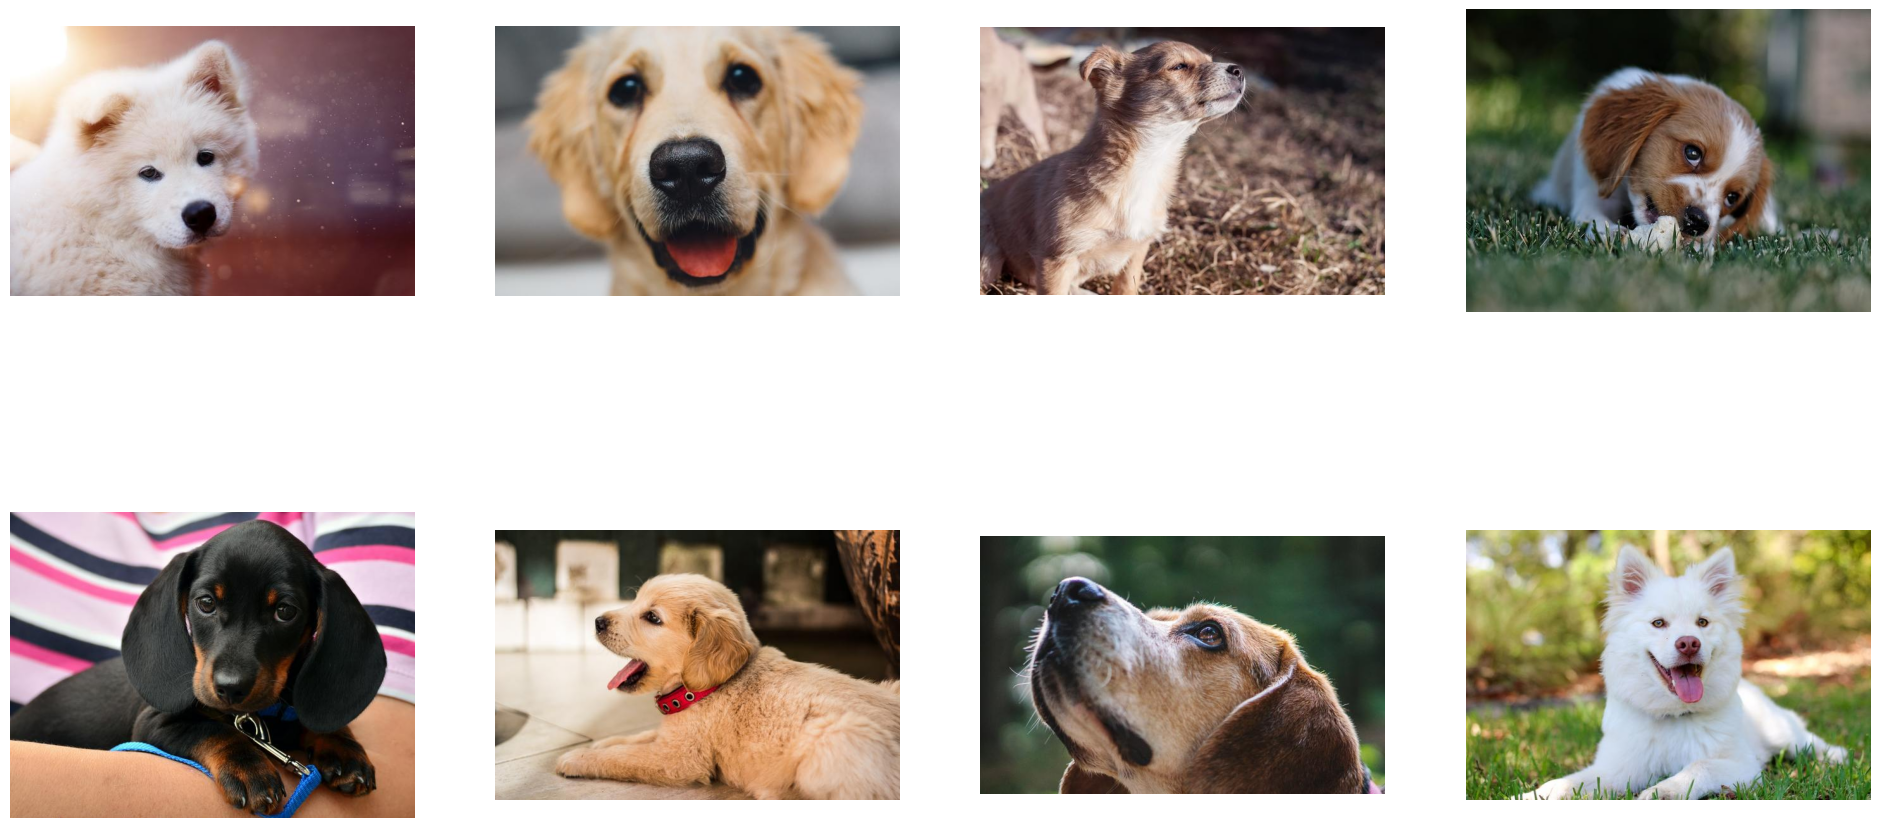

In [8]:
show_images(images)

## Adding Augmentations

### Random Shuffle

As we can see from the example above, the first batch of images returned by our pipeline contains only dogs. That is because we did not shuffle our dataset, and so `fn.readers.file` returns images in lexicographic order.

Let us make a new pipeline, that will change that.

In [9]:
@pipeline_def
def shuffled_pipeline():
    jpegs, labels = fn.readers.file(
        file_root=image_dir, random_shuffle=True, initial_fill=21
    )
    images = fn.decoders.image(jpegs, device="cpu")

    return images, labels

We made 2 changes to the `simple_pipeline` to obtain the `shuffled_pipeline` - we added 2 arguments to the `fn.readers.file` operation

* `random_shuffle` enables shuffling of images in the reader. Shuffling is performed by using a buffer of images read from disk. When the reader is asked to provide the next image, it randomly selects an image from the buffer, outputs it and immediately replaces that spot in the buffer with a freshly read image.
* `initial_fill` sets the capacity of the buffer. The default value of this parameter (1000), well suited for datasets containing thousands of examples, is too big for our very small dataset, which contains only 21 images. This could result in frequent duplicates in the returned batch. That is why in this example we set it to the size of our dataset.
 
Let us test the result of this modification.

In [10]:
pipe = shuffled_pipeline(
    batch_size=max_batch_size, num_threads=1, device_id=0, seed=1234
)

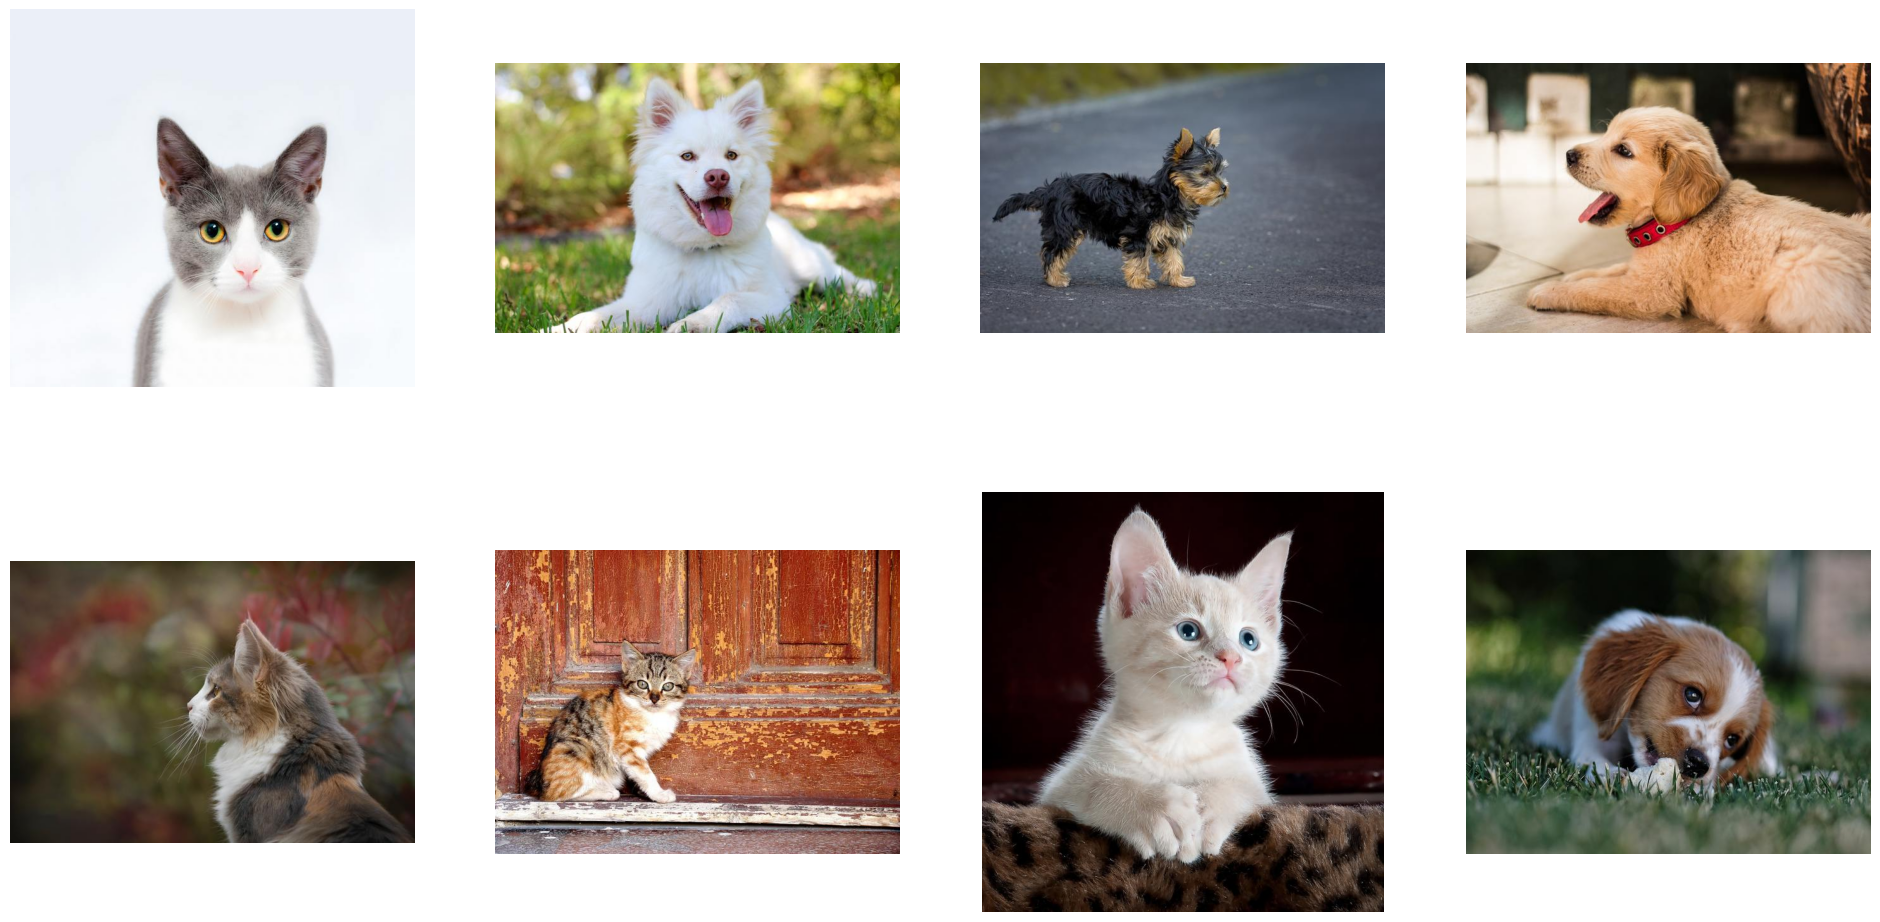

In [11]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

Now the images returned by the pipeline are shuffled properly.

### Augmentations

DALI can not only read images from disk and batch them into tensors, it can also perform various augmentations on those images to improve Deep Learning training results.

One example of such augmentations is rotation. Let us make a new pipeline, which rotates the images before outputting them.

In [12]:
@pipeline_def
def rotated_pipeline():
    jpegs, labels = fn.readers.file(
        file_root=image_dir, random_shuffle=True, initial_fill=21
    )
    images = fn.decoders.image(jpegs, device="cpu")
    rotated_images = fn.rotate(images, angle=10.0, fill_value=0)

    return rotated_images, labels

To do that, we added a new operation to our pipeline: `fn.rotate`.

As we can see in the [documentation](../../supported_ops.html?#nvidia.dali.fn.rotate), `rotate` can take multiple arguments, but only one of them beyond `input` is required - `angle` tells the operator how much it should rotate images. We also specified `fill_value` to better visualise the results.

Let us test the newly created pipeline:

In [13]:
pipe = rotated_pipeline(
    batch_size=max_batch_size, num_threads=1, device_id=0, seed=1234
)
pipe.build()

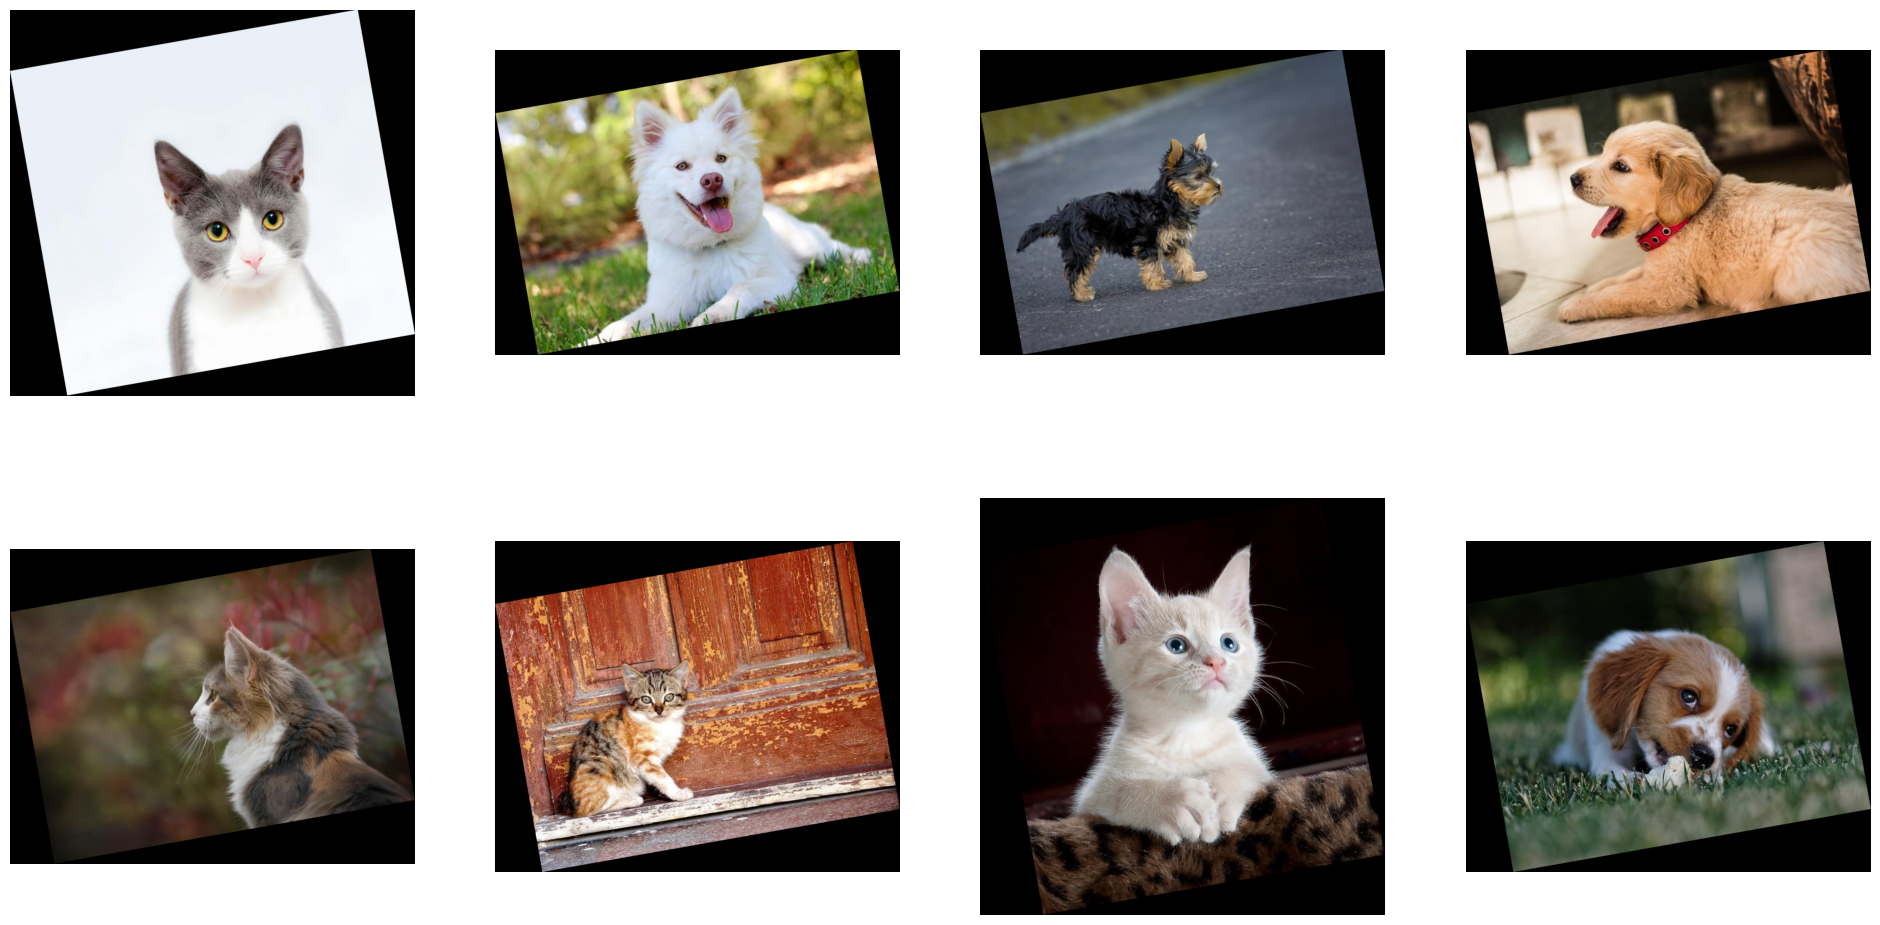

In [14]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

### Tensors as Arguments and Random Number Generation

Rotating every image by 10 degrees is not that interesting. To make a meaningful augmentation, we would like an operator that rotates our images by a random angle in a given range. 

Rotate's `angle` parameter can accept `float` or `float tensor` types of values. The second option, `float tensor`, enables us to feed the operator with different rotation angles for every image, via a tensor produced by other operation.

Random number generators are examples of operations that one can use with DALI. Let us use `fn.random.uniform` to make a pipeline that rotates images by a random angle.

> **_NOTE_**
>
> Keep in mind, that every time you pass an output of a DALI operator to another as a named keyword argument that data must be placed on the CPU. In the example below, we use the output of ``random.uniform`` (which has a default device='cpu') as ``angle`` keyword argument to ``rotate``.
>
>  Such arguments in DALI are called "argument inputs". More information about them can be found in the [pipeline documentation section](../../pipeline.html?#processing-graph-structure).
>
> Regular inputs (non-named, positional ones) do not have such constraints and can use either CPU or GPU data, as shown below.

In [15]:
@pipeline_def
def random_rotated_pipeline():
    jpegs, labels = fn.readers.file(
        file_root=image_dir, random_shuffle=True, initial_fill=21
    )
    images = fn.decoders.image(jpegs, device="cpu")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    rotated_images = fn.rotate(images, angle=angle, fill_value=0)

    return rotated_images, labels

This time, instead of providing a fixed value for the `angle` argument, we set it to the output of the `fn.random.uniform` operator.

Let us check the result:

In [16]:
pipe = random_rotated_pipeline(
    batch_size=max_batch_size, num_threads=1, device_id=0, seed=1234
)

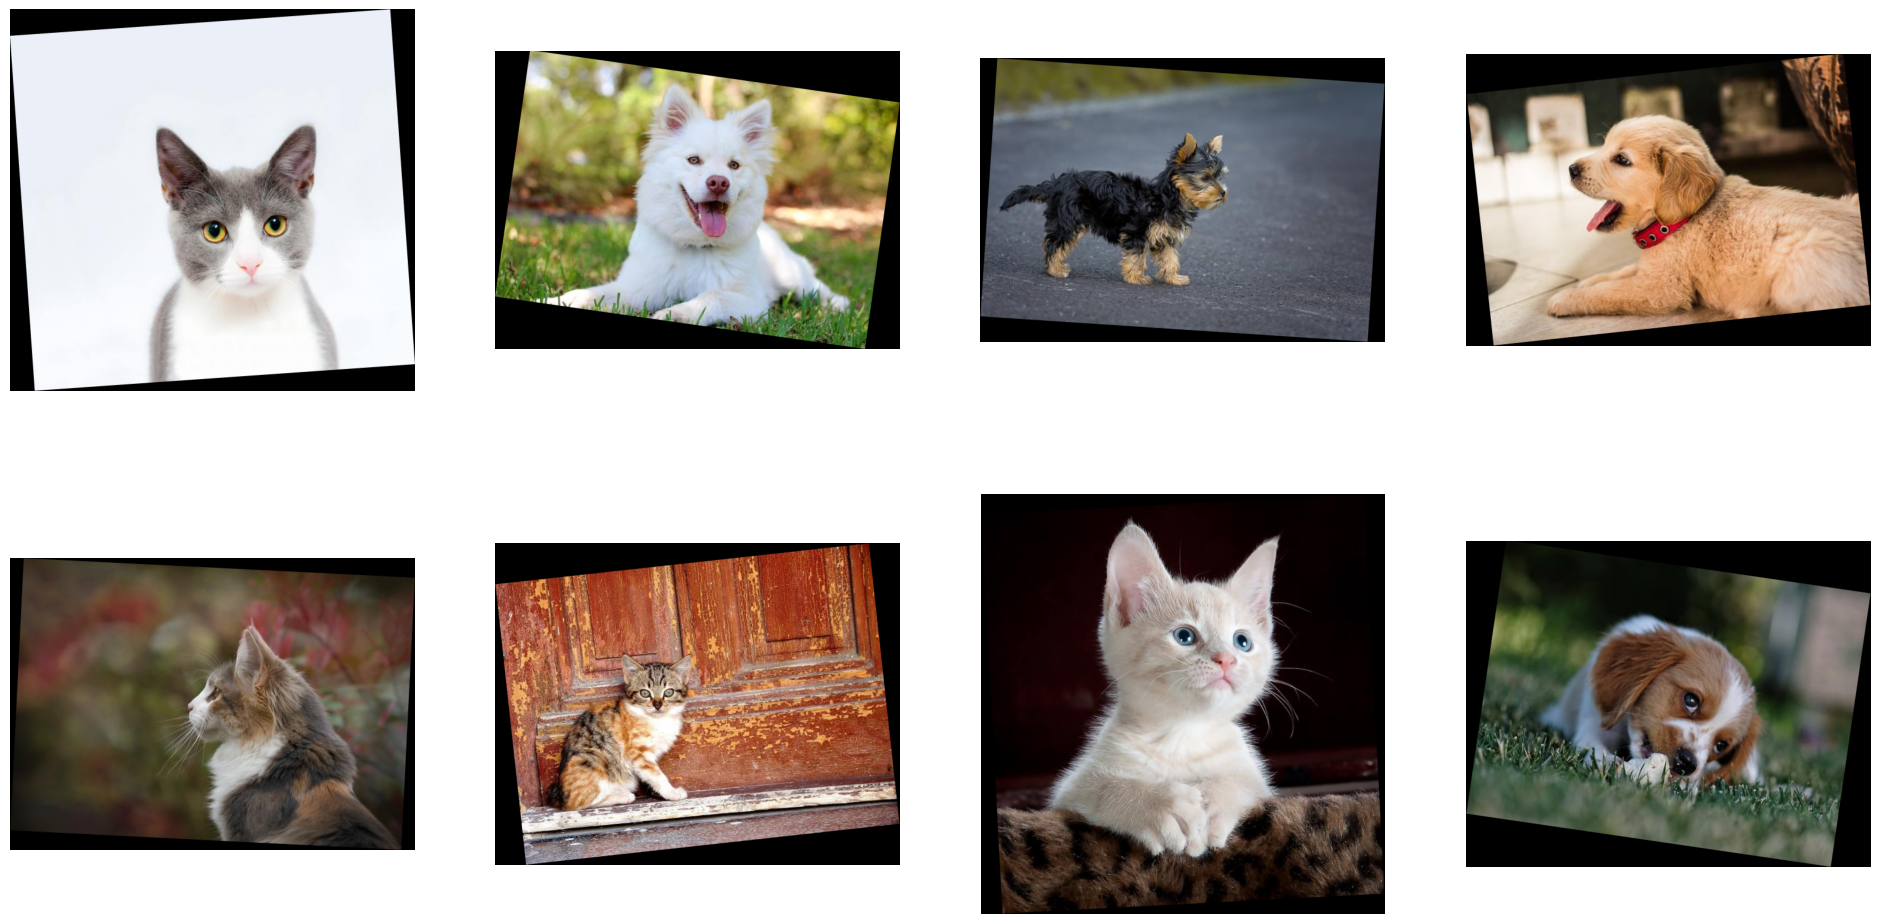

In [17]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images)

This time, the rotation angle is randomly selected from a value range.


## Adding GPU Acceleration

DALI offers access to GPU accelerated operators, that can increase the speed of the input and augmentation pipeline and let it scale to multi-GPU systems.

### Copying Tensors to GPU

Let us modify the previous example of the `random_rotated_pipeline` to use the GPU for the rotation.

In [18]:
@pipeline_def
def random_rotated_gpu_pipeline():
    jpegs, labels = fn.readers.file(
        file_root=image_dir, random_shuffle=True, initial_fill=21
    )
    images = fn.decoders.image(jpegs, device="cpu")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    rotated_images = fn.rotate(images.gpu(), angle=angle, fill_value=0)

    return rotated_images, labels

In order to tell DALI that we want to use the GPU, we needed to make only one change to the pipeline. We changed input to the `rotate` operation from `images`, which is a tensor on the CPU, to `images.gpu()` which copies it to the GPU.

In [19]:
pipe = random_rotated_gpu_pipeline(
    batch_size=max_batch_size, num_threads=1, device_id=0, seed=1234
)
pipe.build()

In [20]:
pipe_out = pipe.run()
print(pipe_out)

(TensorListGPU(
    dtype=DALIDataType.UINT8,
    layout="HWC",
    num_samples=8,
    shape=[(641, 680, 3), 
           (513, 694, 3), 
           (469, 668, 3), 
           (495, 684, 3), 
           (478, 662, 3), 
           (548, 690, 3), 
           (703, 676, 3), 
           (568, 704, 3)]), TensorListCPU(
    dtype=DALIDataType.INT32,
    num_samples=8,
    shape=[(1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,)]))


`pipe_out` still contains 2 `TensorLists`, but this time the first output, result of the `rotate` operation, is on the GPU. We cannot access contents of `TensorListGPU` directly from the CPU, so in order to visualize the result we need to copy it to the CPU by using `as_cpu` method.

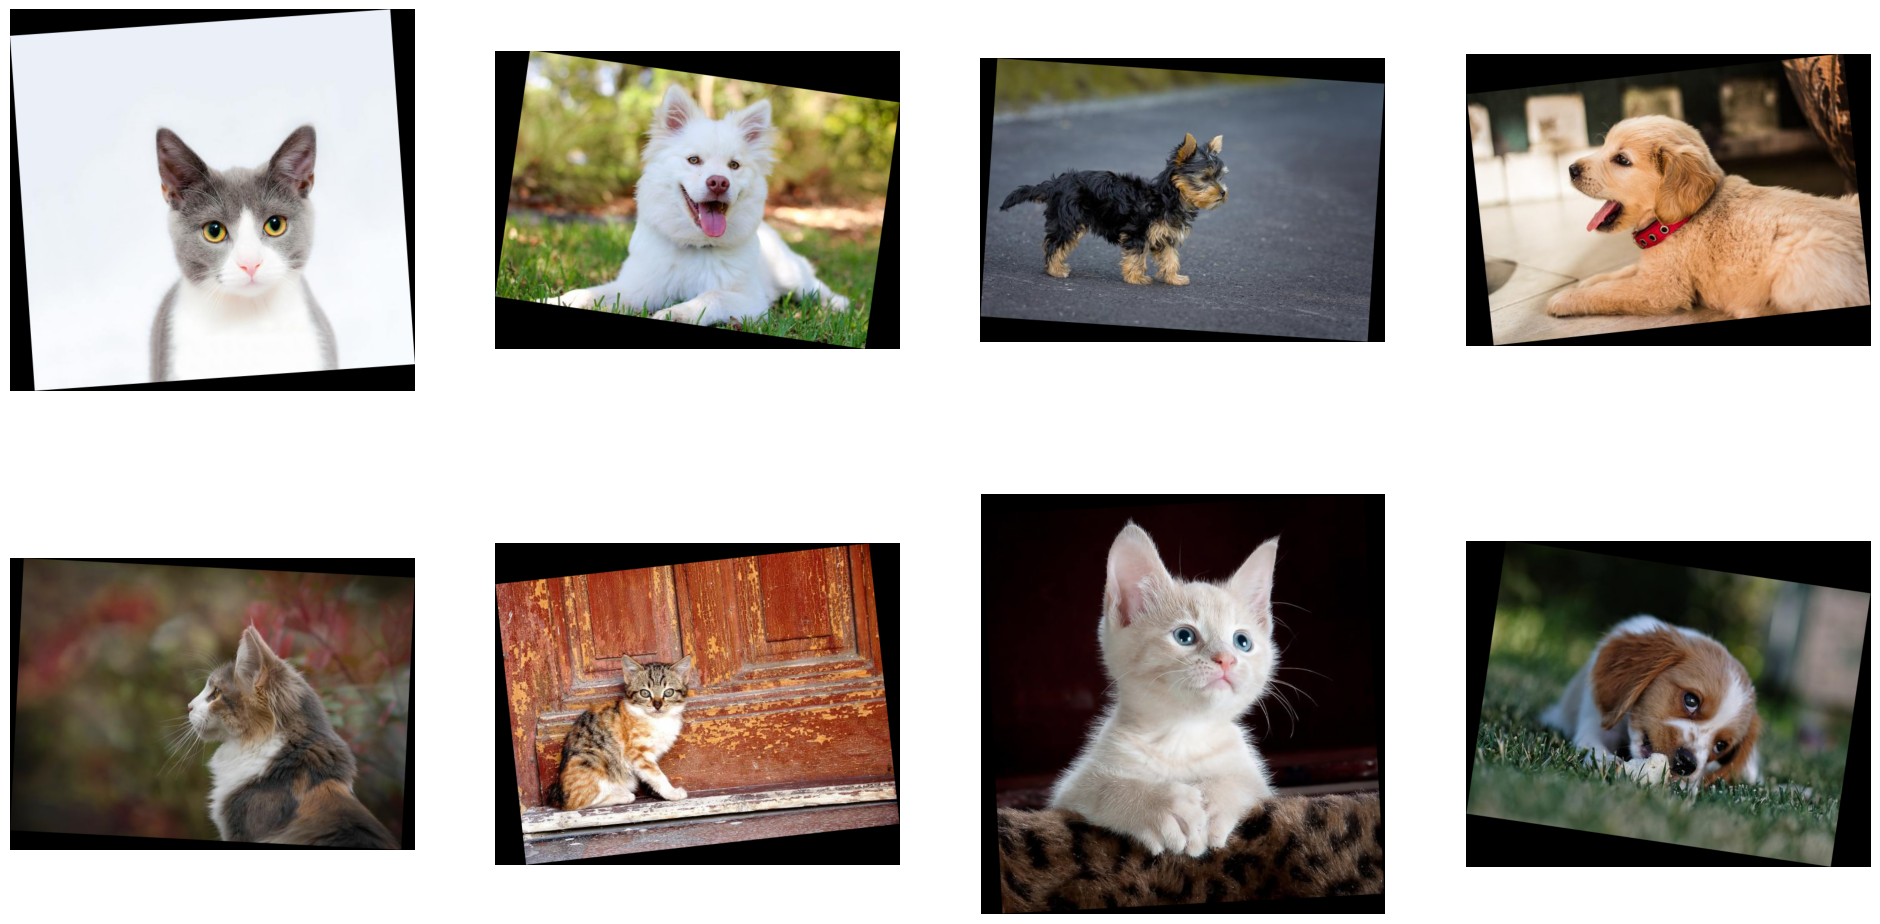

In [21]:
images, labels = pipe_out
show_images(images.as_cpu())

### Hybrid Decoding

Sometimes, especially for higher resolution images, decoding images stored in JPEG format may become a bottleneck. To address this problem, nvJPEG and nvJPEG2000 libraries were developed. They split the decoding process between CPU and GPU, significantly reducing the decoding time.

Specifying "mixed" device parameter in `fn.decoders.image` enables nvJPEG and nvJPEG2000 support. Other file formats are still decoded on the CPU.

In [22]:
@pipeline_def
def hybrid_pipeline():
    jpegs, labels = fn.readers.file(
        file_root=image_dir, random_shuffle=True, initial_fill=21
    )
    images = fn.decoders.image(jpegs, device="mixed")

    return images, labels

`fn.decoders.image` with `device=mixed` uses a hybrid approach of computation that employs both the CPU and the GPU. This means that it accepts CPU inputs, but returns GPU outputs. That is why `images` objects returned from the pipeline are of type `TensorListGPU`.

In [23]:
pipe = hybrid_pipeline(
    batch_size=max_batch_size, num_threads=1, device_id=0, seed=1234
)
pipe.build()

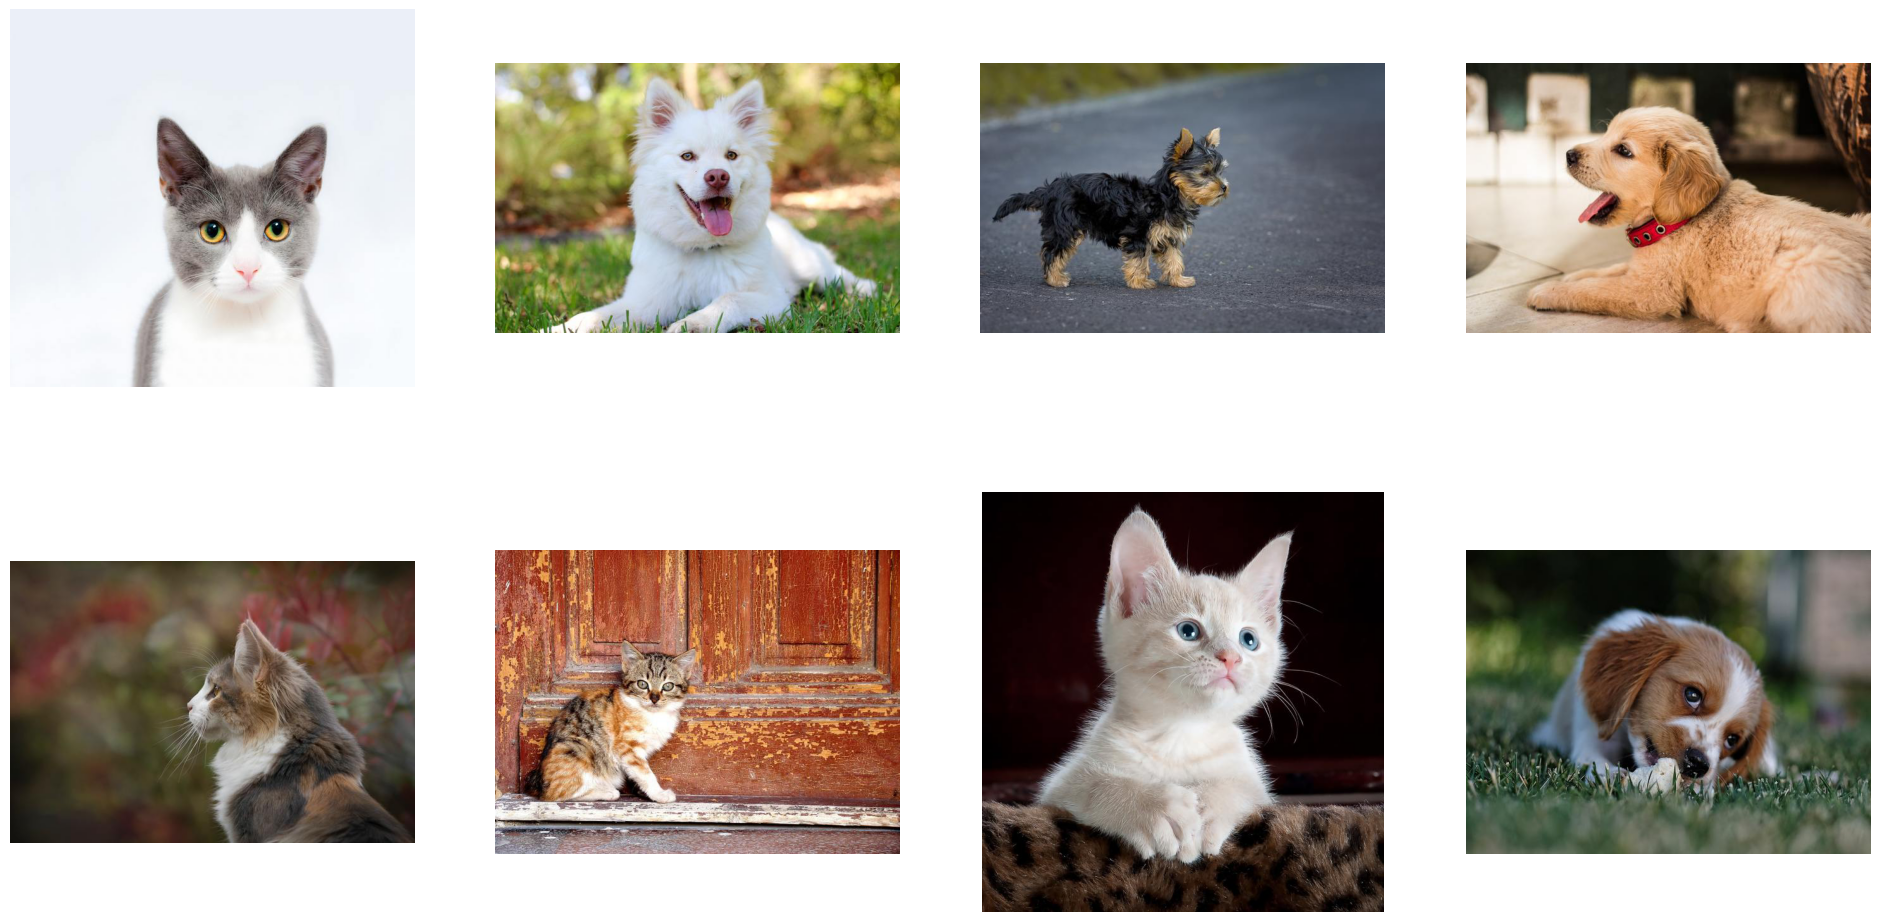

In [24]:
pipe_out = pipe.run()
images, labels = pipe_out
show_images(images.as_cpu())

Let us compare the speed of `fn.decoders.image` for 'cpu' and 'mixed' backends by measuring speed of `shuffled_pipeline` and `hybrid_pipeline` with 4 CPU threads.

In [25]:
from timeit import default_timer as timer

test_batch_size = 64


def speedtest(pipeline, batch, n_threads):
    pipe = pipeline(batch_size=batch, num_threads=n_threads, device_id=0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 20
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch) / t))

In [26]:
speedtest(shuffled_pipeline, test_batch_size, 4)

Speed: 4134.111213620402 imgs/s


In [27]:
speedtest(hybrid_pipeline, test_batch_size, 4)

Speed: 25968.79847910374 imgs/s


As we can see, using GPU accelerated decoding resulted in significant speedup.